In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import numpy as np
from jax import jit, vmap, grad, value_and_grad, pmap
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

key = jax.random.PRNGKey(0)

In [2]:
def perceptron(layer_widths,parent_key, scale=0.01):

  params = []
  for p, q, key in zip(layer_widths[:-1], layer_widths[1:], jax.random.split(parent_key, num=len(layer_widths)-1)):
    w, b = jax.random.split(key)
    params.append([scale*jax.random.normal(w, shape=(q, p)), scale*jax.random.normal(b, shape=(q,))])
  return params

print(jax.tree_map(lambda x:x.shape,perceptron([784,512,256,10],key)))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [3]:
def predict(params, x):
  hidden_layers = params[:-1]
  activation = x
  for w, b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w,activation)+b)

  w_last, b_last = params[-1]
  logits = jnp.dot(w_last, activation)+b_last
  return logits - logsumexp(logits)

batched_MLP_predict = vmap(predict, in_axes=(None,0))

In [18]:
def custom_transform(x):
  return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
  transposed_data = list(zip(*batch))

  labels = np.array(transposed_data[1])
  imgs = np.array(transposed_data[0])
  return imgs,labels


train_dataset = MNIST(root='train_mnist', train=True, download= True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train= False, download= True, transform = custom_transform )
batch_size = 128
img = train_dataset[0][0]
print(img.shape)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, sampler=None,collate_fn= custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

(784,)
(128, 784) float32 (128,) int64


In [5]:
def loss_func(params, imgs, gt_lbls):
    return -jnp.mean(batched_MLP_predict(params, imgs) * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_func)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = perceptron([np.prod((28,28)), 512, 256, len(MNIST.classes)], key)
for epoch in range(5):
    for cnt, (imgs, lbls) in enumerate(train_loader):
        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

0.24260469
0.09087726
0.053342488
0.042885616
0.047708005
0.02604251
0.03798076
0.021008145
0.039591707
0.043994814
Epoch 0, train acc = 0.9143999814987183 test acc = 0.9177999496459961
0.027869707
0.025654862
0.022173157
0.02054069
0.03394743
0.024394639
0.032333013
0.030117124
0.025959974
0.01813677
Epoch 1, train acc = 0.9363999962806702 test acc = 0.9355999827384949
0.01898101
0.017320886
0.013933412
0.022037804
0.019508507
0.01611787
0.024927486
0.029355094
0.02862677
0.017472556
Epoch 2, train acc = 0.946316659450531 test acc = 0.9436999559402466
0.019586999
0.014580408
0.02541149
0.02045689
0.015024898
0.017970493
0.01809365
0.009693205
0.013777402
0.011030308
Epoch 3, train acc = 0.9528666734695435 test acc = 0.949999988079071
0.010929279
0.02372255
0.013016467
0.012304547
0.017461935
0.015203603
0.013762377
0.012463077
0.015798276
0.011212924
Epoch 4, train acc = 0.9581833481788635 test acc = 0.9542999863624573


preiction:  4
actual:  4


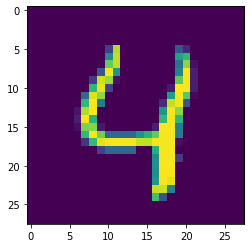

In [17]:
import matplotlib.pyplot as plt

imgs, lbls = next(iter(test_loader))
img = imgs[4].reshape((28, 28))
print('preiction: ', jnp.argmax(predict(MLP_params, np.ravel(img))))
print('actual: ', lbls[4])

plt.imshow(img)
plt.show()